In [1]:
!pip install phonetics
import pandas as pd
import numpy as np
from unidecode import unidecode
import phonetics
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
import xgboost as xgb
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
%matplotlib inline

  Stored in directory: /tmp/.cache/pip/wheels/ad/ca/b1/e41e662f86b95d185748da378fdc995c1520b0d5628c46a0b7
Successfully built phonetics
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class GenderClassification:
    def __init__(self, dataset_url='../input/nat2017.csv'):
        self.dataset_url = dataset_url
        self.df = pd.read_csv(self.dataset_url,sep=";",engine='python')
        self.metaphone_pipeline = Pipeline([
            ('selector', DFSelector('phonetics')),
            ('encoder', CountVectorizer(ngram_range=(3, 4), analyzer='char', lowercase=False))
        ])
        self.cat_pipeline = Pipeline([
            ('selector', DFSelector(["vowel_ending", "last", "last_allit"])),
            ('encoder1', OneHotEncoder())
        ])
        self.cnt_pipeline = Pipeline([
            ('selector_cnt', DFSelector('preusuel')),
            ('vec', CountVectorizer(ngram_range=(2, 4), analyzer='char_wb', lowercase=False)),
        ])
        self.preprocessing = FeatureUnion(transformer_list=[
            ("metaphone_pipeline", self.metaphone_pipeline),
            ("cat_pipeline", self.cat_pipeline),
            ("cnt_pipeline", self.cnt_pipeline)
        ])
        self.xgb_params = {
            'eta': 0.1, 
            'max_depth': 5, 
            'subsample': 0.5, 
            'colsample_bytree': 0.5, 
            'objective': 'binary:hinge', 
            'eval_metric': 'error', 
            'seed': 1234
        }
        
    def data_cleaning(self, *name_to_pred):
        df = self.df.copy(deep=True)
        df = df.drop(df[df.annais == 'XXXX'].index)
        df = df.drop(df[df.preusuel == '_PRENOMS_RARES'].index)
        df = df.drop('annais', 1)
        df = df.drop('nombre', 1)
        df['preusuel'] = df['preusuel'].str.capitalize()
        df['preusuel'] = df['preusuel'].astype(str)
        df['preusuel'] = df['preusuel'].apply(unidecode)
        df['preusuel'] = df['preusuel'].str.replace('\W', ' ')
        df.loc[df['sexe'] == 2, 'sexe'] = 0
        male = df.loc[self.df['sexe'] == 1].copy(deep=True)
        male.drop_duplicates(subset = "preusuel", keep = "last", inplace = True)
        female = df.loc[df['sexe'] == 0].copy(deep=True)
        female.drop_duplicates(subset = "preusuel", keep = "last", inplace = True)
        df = male.append(female, ignore_index=True)
        if len(name_to_pred) != 0:
            df = pd.concat([df, pd.DataFrame({'sexe': np.nan, 'preusuel': name_to_pred}, index=[df.shape[0]])], sort=True)
        return df
    
    def feature_engineering(self, df):
        df['vowel_ending'] = df['preusuel'].astype(str).apply(lambda x: x[-1].lower() in set('aeiouy'))
        df['last'] = df['preusuel'].astype(str).apply(lambda x: x[-1].lower())
        df['last_allit'] = df['preusuel'].astype(str).apply(lambda x: x[-1] == x[-2] if len(x) >= 2 else False)
        df['phonetics'] = df['preusuel'].astype(str).apply(lambda x: phonetics.metaphone(x))
        return df
    
    def data_processing(self, df, existence_of_a_name_to_predict = False):
        X, y = self.preprocessing.fit_transform(df), df['sexe'][:df.shape[0]-1]
        
        if existence_of_a_name_to_predict:
            X_pred = csr_matrix(X.todense()[X.shape[0]-1])
            X = csr_matrix(np.delete(X.todense(), X.shape[0]-1, axis=0))
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

        y_train = y_train.values
        y_test = y_test.values
        y_val = y_val.values

        svd = TruncatedSVD(200)

        X_train_reduced = svd.fit_transform(X_train)
        X_test_reduced = svd.transform(X_test)
        X_val_reduced = svd.transform(X_val)
        X_pred_reduced = svd.transform(X_pred) if existence_of_a_name_to_predict else None
        
        return X_train_reduced, y_train, X_test_reduced, y_test, X_val_reduced, y_val, X_pred_reduced
    
    def plot(self, X_train_reduced, y_train):
        plt.figure(figsize=(12, 12))
        plt.title('Truncated Data')
        colors = {k: sns.xkcd_rgb[v] for k, v in [(0, 'bluish'), (1, 'barbie pink')]}
        for data, label in zip(X_train_reduced[:1000], y_train[:1000]):
            plt.scatter(data[0], data[1], color=colors[label])
            
    def train(self, X_train_reduced, y_train, X_val_reduced, y_val, X_test_reduced, y_test):
        d_train = xgb.DMatrix(X_train_reduced, y_train)
        d_val = xgb.DMatrix(X_val_reduced, y_val)
        d_test = xgb.DMatrix(X_test_reduced, y_test)
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        watchlist = [(d_train, 'train'), (d_val, 'valid')]
        model_xgb = xgb.train(self.xgb_params, d_train, 500, watchlist, verbose_eval=1, early_stopping_rounds=20)
        return model_xgb
    
    def predict(self, X_test_reduced, y_test, model_xgb):
        d_test = xgb.DMatrix(X_test_reduced, y_test)
        return model_xgb.predict(d_test)
    
    def evaluate(self, predictions, y_test):
        wrong = np.where(predictions!=y_test)
        correct = predictions.shape[0] - wrong[0].shape[0]
        ratio = correct / predictions.shape[0]
        print("{} of {}".format(correct, predictions.shape[0]))
        print("{:.2%}".format(ratio))
    
    def inference(self, X_pred_reduced):
        try:
            res = model_xgb.predict(xgb.DMatrix(X_pred_reduced))
        except:
            print("Erreur verifie que vous avez bien entré le nom à prédire.")
        return res

In [11]:
gc = GenderClassification()
name = input("Entrer un nom : ")
print(''.__eq__(name))

Entrer un nom : Yanz
False


In [12]:
if ''.__eq__(name):
    df = gc.data_cleaning()
else:
    df = gc.data_cleaning(name) 
df = gc.feature_engineering(df)

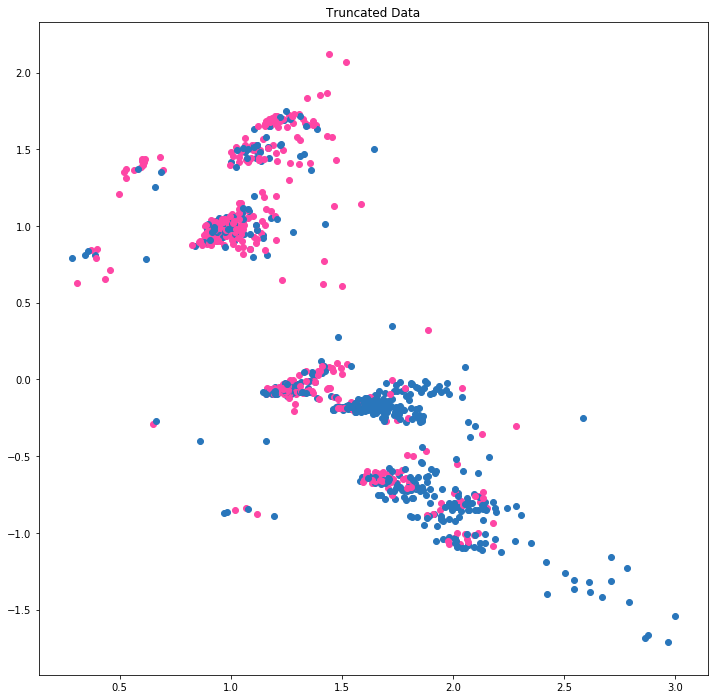

In [13]:
X_train_reduced, y_train, X_test_reduced, y_test, X_val_reduced, y_val, X_pred_reduced = gc.data_processing(df, True)
gc.plot(X_train_reduced, y_train)

In [9]:
model_xgb = gc.train(X_train_reduced, y_train, X_val_reduced, y_val, X_test_reduced, y_test)
predictions = gc.predict(X_test_reduced, y_test, model_xgb)
gc.evaluate(predictions, y_test)

[0]	train-error:0.535452	valid-error:0.556276
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[1]	train-error:0.535452	valid-error:0.556276
[2]	train-error:0.535452	valid-error:0.556276
[3]	train-error:0.535452	valid-error:0.556276
[4]	train-error:0.535452	valid-error:0.556276
[5]	train-error:0.533428	valid-error:0.554207
[6]	train-error:0.422476	valid-error:0.446207
[7]	train-error:0.320121	valid-error:0.339862
[8]	train-error:0.27414	valid-error:0.293379
[9]	train-error:0.251471	valid-error:0.268414
[10]	train-error:0.239654	valid-error:0.251724
[11]	train-error:0.232711	valid-error:0.245931
[12]	train-error:0.227469	valid-error:0.239586
[13]	train-error:0.223239	valid-error:0.234345
[14]	train-error:0.22002	valid-error:0.229655
[15]	train-error:0.217859	valid-error:0.228276
[16]	train-error:0.216894	valid-error:0.226207
[17]	train-error:0.215008	valid-error:0.22331
[18]	train-error:0.2

[171]	train-error:0.148198	valid-error:0.194897
[172]	train-error:0.147738	valid-error:0.195172
[173]	train-error:0.147324	valid-error:0.195448
[174]	train-error:0.147186	valid-error:0.194621
[175]	train-error:0.146956	valid-error:0.195586
[176]	train-error:0.146496	valid-error:0.195862
[177]	train-error:0.146174	valid-error:0.196552
[178]	train-error:0.145761	valid-error:0.195172
[179]	train-error:0.145669	valid-error:0.19531
[180]	train-error:0.144841	valid-error:0.194759
[181]	train-error:0.144611	valid-error:0.194345
[182]	train-error:0.143691	valid-error:0.194897
[183]	train-error:0.143507	valid-error:0.195172
[184]	train-error:0.143094	valid-error:0.195172
[185]	train-error:0.143002	valid-error:0.195586
[186]	train-error:0.142772	valid-error:0.195448
[187]	train-error:0.142634	valid-error:0.195724
[188]	train-error:0.142266	valid-error:0.195862
[189]	train-error:0.142082	valid-error:0.196414
[190]	train-error:0.142174	valid-error:0.196552
[191]	train-error:0.141254	valid-error:0.

In [14]:
if ''.__eq__(name) == False :
    print(gc.inference(X_pred_reduced)[0])

1.0
